In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Mock dataset (replace with your actual data)
data = {
    "NR_UE_PCI_0": 48,               # Serving cell PCI
    "NR_UE_Nbr_PCI_0": 76,           # Neighbor 1 PCI
    "NR_UE_Nbr_PCI_1": 0,           # Neighbor 2 PCI
    "NR_UE_Nbr_RSRP_0": -93.6,          # RSRP of neighbor 1 (dBm)
    "NR_UE_Nbr_RSRP_1": 0,          # RSRP of neighbor 2 (dBm)
    "NR_UE_Timing_Advance": 0,        # Timing Advance (TA) in microseconds
}

# Base station (gNB) positions (replace with real coordinates)
gNB_positions = {
    100: np.array([41.1080861, 29.0281222]),            # Serving cell at origin
    101: np.array([41.1054694, 29.0278333
]),          # Neighbor 1 at (500m, 0)
    102: np.array([0, 0]),           # Neighbor 2 at (0, 500m)
}

In [8]:
def rsrp_to_distance(rsrp, tx_power=30, pl0=30, n=3.5):
    """Convert RSRP (dBm) to distance using log-distance path loss model."""
    path_loss = tx_power - rsrp       # Path loss = TxPower - RSRP
    distance = 10 ** ((path_loss - pl0) / (10 * n))  # Log-distance formula
    return distance

# Example: Estimate distances to neighbors
dist_rsrp_0 = rsrp_to_distance(data["NR_UE_Nbr_RSRP_0"])
dist_rsrp_1 = rsrp_to_distance(data["NR_UE_Nbr_RSRP_1"])
print(f"RSSI-based distances: {dist_rsrp_0:.1f}m, {dist_rsrp_1:.1f}m")

RSSI-based distances: 472.4m, 1.0m


In [9]:
# Timing Advance (TA) to distance (1 TA ~ 78m in 5G)
ta_distance = data["NR_UE_Timing_Advance"] * 78  # Approximate conversion

# Simulate TDoA: Assume TA differences between cells (mock)
tdoa_diff = {
    (100, 101): 0.5e-6,  # Time difference (s) between serving and neighbor 1
    (100, 102): 0.3e-6,  # Time difference (s) between serving and neighbor 2
}
speed_of_light = 3e8     # m/s

# Hyperbolic equations for TDoA
def tdoa_equations(pos, tdoa_diff, gNB_positions):
    x, y = pos
    equations = []
    for (pci1, pci2), dt in tdoa_diff.items():
        x1, y1 = gNB_positions[pci1]
        x2, y2 = gNB_positions[pci2]
        d1 = np.sqrt((x - x1)**2 + (y - y1)**2)
        d2 = np.sqrt((x - x2)**2 + (y - y2)**2)
        equations.append((d1 - d2) - (dt * speed_of_light))
    return equations

In [10]:
def hybrid_positioning(gNB_positions, tdoa_diff, dist_rsrp, initial_guess=[100, 100]):
    # Combine TDoA and RSSI equations
    def residuals(pos):
        # TDoA residuals
        res_tdoa = tdoa_equations(pos, tdoa_diff, gNB_positions)
        
        # RSSI residuals (distance mismatch)
        res_rsrp = []
        for i, (pci, dist) in enumerate(dist_rsrp.items()):
            gNB_pos = gNB_positions[pci]
            d_est = np.sqrt((pos[0] - gNB_pos[0])**2 + (pos[1] - gNB_pos[1])**2)
            res_rsrp.append(d_est - dist)
        
        # Weighted combination (adjust weights based on confidence)
        return np.concatenate([res_tdoa, res_rsrp])
    
    # Solve using nonlinear least squares
    result = least_squares(residuals, initial_guess)
    return result.x

# Mock RSSI distances (key: PCI, value: distance)
dist_rsrp = {
    101: dist_rsrp_0,
    102: dist_rsrp_1,
}

# Run hybrid positioning
ue_pos = hybrid_positioning(gNB_positions, tdoa_diff, dist_rsrp)
print(f"Estimated UE position: {ue_pos}")

Estimated UE position: [-172.79354095 -122.00674458]


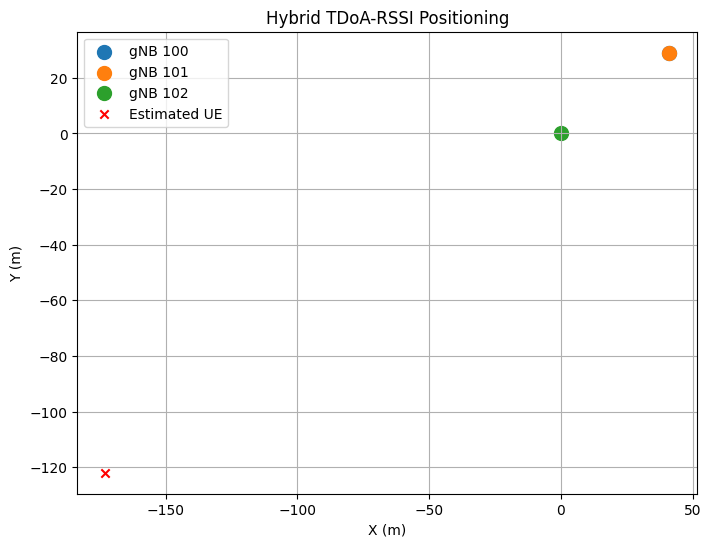

In [11]:
# Plot base stations and estimated UE position
plt.figure(figsize=(8, 6))
for pci, pos in gNB_positions.items():
    plt.scatter(*pos, label=f"gNB {pci}", s=100)
plt.scatter(*ue_pos, color="red", marker="x", label="Estimated UE")
plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.title("Hybrid TDoA-RSSI Positioning")
plt.legend(); plt.grid()
plt.show()